In [2]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
from math import sqrt
from PIL import Image

In [5]:
tf.version.VERSION

'2.9.0'

In [3]:
with open('./images_captions.csv') as f:
    captions= pd.read_csv(f)
print(captions)

                   image                                            caption
0      ./train/png/0.png  <ellipse cx="32.0" cy="8.0" fill="silver" rx="...
1      ./train/png/1.png  <ellipse cx="8.0" cy="8.0" fill="maroon" rx="1...
2      ./train/png/2.png  <ellipse cx="8.0" cy="56.0" fill="cyan" rx="8....
3      ./train/png/3.png  <rect fill="red" height="16.0" width="16.0" x=...
4      ./train/png/4.png  <ellipse cx="8.0" cy="56.0" fill="lime" rx="8....
..                   ...                                                ...
495  ./train/png/495.png  <ellipse cx="8.0" cy="8.0" fill="silver" rx="1...
496  ./train/png/496.png  <ellipse cx="32.0" cy="8.0" fill="magenta" rx=...
497  ./train/png/497.png  <rect fill="magenta" height="32.0" width="8.0"...
498  ./train/png/498.png  <ellipse cx="8.0" cy="32.0" fill="gray" rx="32...
499  ./train/png/499.png  <ellipse cx="56.0" cy="32.0" fill="cyan" rx="3...

[500 rows x 2 columns]


In [4]:
def preprocess(text):
    text = text.lower()
    # text = re.sub(r'[^\w\s]', '', text)
    # text = re.sub('\s+', ' ', text)
    # text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [5]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

,image,caption
0,./train/png/0.png,"[start] <ellipse cx=""32.0"" cy=""8.0"" fill=""silv..."
1,./train/png/1.png,"[start] <ellipse cx=""8.0"" cy=""8.0"" fill=""maroo..."
2,./train/png/2.png,"[start] <ellipse cx=""8.0"" cy=""56.0"" fill=""cyan..."
3,./train/png/3.png,"[start] <rect fill=""red"" height=""16.0"" width=""..."
4,./train/png/4.png,"[start] <ellipse cx=""8.0"" cy=""56.0"" fill=""lime..."


[start] <rect fill="teal" height="8.0" width="32.0" x="56.0" y="8.0" /><rect fill="red" height="16.0" width="8.0" x="8.0" y="56.0" /> [end]



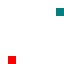

In [6]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

In [7]:
MAX_LENGTH = 80
VOCABULARY_SIZE = 10000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512

In [8]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

2023-04-13 13:54:38.387114: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-13 13:54:38.387819: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-13 13:54:38.452687: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-13 13:54:38.518949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [9]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [10]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index], 
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [11]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(400, 400, 100, 100)

In [12]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    caption = tokenizer(caption)
    return img, caption

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [15]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet'
    )
    inception_v3.trainable = False

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [16]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")
    

    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [17]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))
    

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [18]:
Embeddings(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)(next(iter(train_dataset))[1]).shape

TensorShape([32, 80, 512])

In [19]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
    

    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None
        
        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [20]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    
    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)
        
        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )
    
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [21]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [22]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

checkpoint_path = "./saved-model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

In [29]:
history = caption_model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=[early_stopping, cp_callback]
)

Epoch 1/5


2023-03-27 09:23:27.538726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 3.3509 - acc: 0.1838

2023-03-27 09:23:59.720967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to ./saved-model/cp.ckpt
13/13 [==============================] - 44s 3s/step - loss: 3.3509 - acc: 0.1868 - val_loss: 2.1507 - val_acc: 0.3590
Epoch 2/5
13/13 [==============================] - ETA: 0s - loss: 1.7962 - acc: 0.3769
Epoch 2: saving model to ./saved-model/cp.ckpt
13/13 [==============================] - 31s 2s/step - loss: 1.7962 - acc: 0.3775 - val_loss: 1.6234 - val_acc: 0.4045
Epoch 3/5
13/13 [==============================] - ETA: 0s - loss: 1.5006 - acc: 0.4207
Epoch 3: saving model to ./saved-model/cp.ckpt
13/13 [==============================] - 25s 2s/step - loss: 1.5006 - acc: 0.4213 - val_loss: 1.4939 - val_acc: 0.4275
Epoch 4/5
13/13 [==============================] - ETA: 0s - loss: 1.3549 - acc: 0.4654
Epoch 4: saving model to ./saved-model/cp.ckpt
13/13 [==============================] - 22s 2s/step - loss: 1.3549 - acc: 0.4660 - val_loss: 1.4678 - val_acc: 0.4398
Epoch 5/5
13/13 [==============================] - ETA: 0s - loss: 1.26

In [30]:
idx2word(2).numpy().decode('utf-8')

'/><ellipse'

In [23]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    return img


def generate_caption(img_path, model):
    img = load_image_from_path(img_path)
    img = tf.expand_dims(img, axis=0)
    img_embed = model.cnn_model(img)
    img_encoded = model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

Predicted Caption: <ellipse cx="8.0" cy="56.0" fill="red" rx="8.0" ry="32.0" /><rect fill="purple" height="8.0" width="8.0" x="32.0" y="8.0" /><ellipse cx="32.0" cy="56.0" fill="purple" rx="8.0" ry="32.0" /><rect fill="purple" height="8.0" width="16.0" x="8.0" y="8.0" />

./train/png/126.png


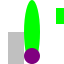

In [37]:
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path, caption_model)
print('Predicted Caption:', pred_caption)
print()
print(img_path)
Image.open(img_path)

Predicted Caption: <ellipse cx="32.0" cy="32.0" fill="black" rx="8.0" ry="8.0" /><ellipse cx="56.0" cy="32.0" fill="purple" rx="8.0" ry="8.0" />

./train/png/266.png


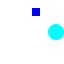

In [33]:
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
print(img_path)
Image.open(img_path)

Predicted Caption: <ellipse cx="32.0" cy="8.0" width="32.0" x="32.0" y="32.0" /><ellipse cx="8.0" cy="56.0" fill="olive" rx="32.0" ry="16.0" /><ellipse cx="32.0" cy="32.0" fill="black" rx="16.0" ry="16.0" />



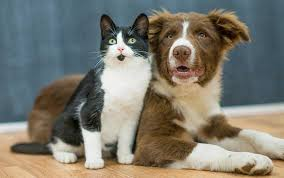

In [34]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT2j6yclbKYDav4BGUKLAdTvSFXp1gtuzy5DQ&usqp=CAU"
im = Image.open(requests.get(url, stream=True).raw)
im.save('tmp.jpg')

pred_caption = generate_caption('tmp.jpg')
print('Predicted Caption:', pred_caption)
print()
im

In [ ]:
# caption_model.save_weights('image_captioning_transformer_weights.h5')

# if not load_weights:
#     from google.colab import drive
#     drive.mount('/content/drive')

# with open('/content/drive/MyDrive/Saved Models/ImageCaptioning/image_captioning_transformer_weights.h5', 'wb') as f:
#     f.write(open('image_captioning_transformer_weights.h5', 'rb').read())

In [24]:
loaded_model = caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

loaded_model.load_weights(checkpoint_path)

Predicted Caption: <ellipse cx="8.0" cy="8.0" fill="blue" rx="8.0" ry="8.0" /><ellipse cx="8.0" cy="32.0" fill="teal" rx="8.0" ry="8.0" /><ellipse cx="8.0" cy="32.0" fill="purple" rx="16.0" ry="8.0" />

./train/png/156.png


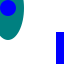

In [26]:
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path, loaded_model)
print('Predicted Caption:', pred_caption)
print()
print(img_path)
Image.open(img_path)

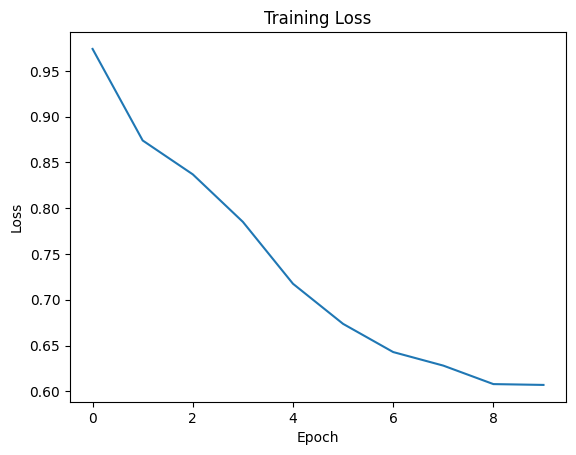

In [7]:
# sample loss data
loss = [.974, .874, .837, 0.7851, .7175, .6737, .6429, .6281, .6079, .607]

# create figure and axis objects
fig, ax = plt.subplots()

# plot loss curve
ax.plot(loss)

# set plot title and axis labels
ax.set_title('Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# show plot
plt.show()

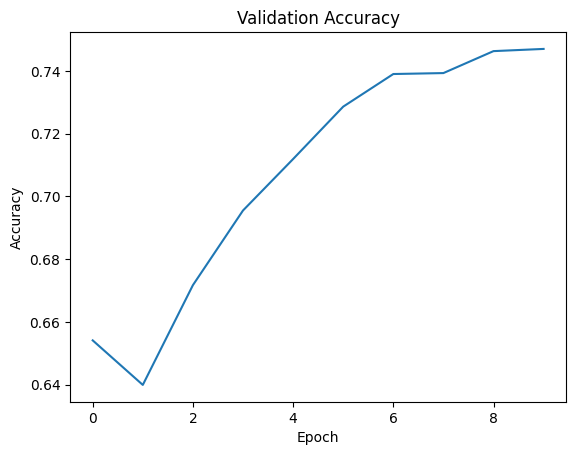

In [8]:
# sample loss data
val_acc_values = [0.6541, 0.6399, 0.6717, 0.6955, 0.7119, 0.7286, 0.739, 0.7393, 0.7463, 0.747]

# create figure and axis objects
fig, ax = plt.subplots()

# plot loss curve
ax.plot(val_acc_values)

# set plot title and axis labels
ax.set_title('Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# show plot
plt.show()